In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.linalg as linalg
import os
import time
from ParticleFilter import sample_normal_model, single_step_particle_filter, normal_model_pdf, single_step_particle_filter_measurement_window
from utils.plotting import draw_ellipse, images_to_gif
from utils.filesTools import get_exp_folder

# modeling 
here we can define all the parameters relevent to our system. 

__spacial cases:__
- if we want a deterministic agent or beacon we can set his covariance to zero, this also need to be done in the particle initialization part 




In [2]:
## setup params
NUM_OF_BEACONS = 4
NUM_OF_AGENTS = 1
STATE_SIZE_2D = 2
SINGLE_RANGE_MEASUREMENT_SIZE = 1
RANGE_MEASUREMENT_SIZE = NUM_OF_BEACONS * SINGLE_RANGE_MEASUREMENT_SIZE * NUM_OF_AGENTS
TOTAL_STATE_SIZE = NUM_OF_AGENTS * STATE_SIZE_2D + NUM_OF_BEACONS * STATE_SIZE_2D
sigma_transition_agent = 0.5
sigma_transition_beacon = 0.3
sigma_measurement = 0.1
stepsize = 2
n_steps = 150
n_particles = 100
# model definition
cov_measurement = np.diag([sigma_measurement**2 for i in range(RANGE_MEASUREMENT_SIZE)])
cov_transition_agent = [sigma_transition_agent**2 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_agent = [0 for i in range(NUM_OF_AGENTS*STATE_SIZE_2D)]
cov_transition_beacon = [sigma_transition_beacon**2 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon = [0 for i in range(NUM_OF_BEACONS*STATE_SIZE_2D)]
# cov_transition_beacon[0:6] = [sigma_transition_beacon**2]*6
cov_transition = np.diag(cov_transition_agent + cov_transition_beacon)


## State Manager
__not do be edited__ 
This section of the code is responsible for managing the state of the system, which includes the positions of agents and beacons in a 2D space.

Here's a breakdown of the functions:

- `get_agent_index(i)`: This function takes an agent's index `i` and returns a slice object that can be used to index into the state vector `x` to get the position of the agent.

- `get_beacon_index(i)`: Similar to `get_agent_index`, this function takes a beacon's index `i` and returns a slice object that can be used to index into the state vector `x` to get the position of the beacon.

- `get_agent_position(x, i)`: This function takes the state vector `x` and an agent's index `i`, and returns the position of the agent.

- `get_beacon_position(x, i)`: This function takes the state vector `x` and a beacon's index `i`, and returns the position of the beacon.

- `state_to_agent_and_beacons_pos(x)`: This function takes the state vector `x` and returns two arrays containing the positions of all agents and beacons, respectively.

- `agent_and_beacons_pos_to_state(agents_pos, beacons_pos)`: This function takes two arrays containing the positions of all agents and beacons, respectively, and returns a state vector `x`.

These functions are used to convert between the state vector representation and the separate agent and beacon position representations, which can be more convenient for certain calculations.

In [4]:
# state manger
get_agent_index = lambda i: slice(i*STATE_SIZE_2D, i*STATE_SIZE_2D + STATE_SIZE_2D)
get_beacon_index = lambda i: slice(STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D, STATE_SIZE_2D*NUM_OF_AGENTS + i*STATE_SIZE_2D + STATE_SIZE_2D)
get_agent_position = lambda x, i: x[get_agent_index(i)]
get_beacon_postion = lambda x, j: x[get_beacon_index(j)]
def state_to_agent_and_beacons_pos(x):
    agents_pos = np.zeros((NUM_OF_AGENTS, STATE_SIZE_2D))
    beacons_pos = np.zeros((NUM_OF_BEACONS, STATE_SIZE_2D))
    for i in range(NUM_OF_AGENTS):
        agents_pos[i] = get_agent_position(x, i)
    for j in range(NUM_OF_BEACONS):
        beacons_pos[j] = get_beacon_postion(x, j)
    return agents_pos, beacons_pos
def agent_and_beacons_pos_to_state(agents_pos, beacons_pos):
    x = np.zeros(TOTAL_STATE_SIZE)
    for i in range(NUM_OF_AGENTS):
        x[get_agent_index(i)] = agents_pos[i]
    for j in range(NUM_OF_BEACONS):
        x[get_beacon_index(j)] = beacons_pos[j]
    return x

## State Propagation and Measurement Model

This section of the code is responsible for propagating the state of the system and generating the measurement model.

Here's a breakdown of the functions:

- `propagate_state(x, u)`: This function propagates the state based on the control input `u` and a normal model. It adds a normally distributed noise with covariance `cov_transition` to the state `x`.

- `calculate_true_range_meas(x)`: This function calculates the true range measurements. It calculates the Euclidean distance between each agent and each beacon. The state vector `x` contains the positions of the agents and beacons.

- `measurements_model(x, cov = cov_measurement)`: This function generates the range measurements model. It adds a normally distributed noise with covariance `cov_measurement` to the true range measurements.

- `measurements_likelihood(z, x)`: This function calculates the likelihood of the measurements `z` given the state `x`. It uses a normal probability density function with the true range measurements as the mean and the measurement covariance as the covariance.

These functions are used to simulate the dynamics of the system and the measurements of the agents.

In [3]:
## model definition
'''
Function to propagate the state based on the control input and a normal model
'''
propagate_state_function = lambda x, u: x + sample_normal_model(u, cov_transition)


def calculate_true_range_meas(x):
    """
    Function to calculate the true range measurements.
    It calculates the Euclidean distance between each agent and each beacon.
    """
    z = np.zeros(RANGE_MEASUREMENT_SIZE)
    for i in range(NUM_OF_AGENTS):
        current_agent_position = x[get_agent_index(i)]
        for j in range(NUM_OF_BEACONS):
            current_beacon_position = x[get_beacon_index(j)]
            z[i*NUM_OF_BEACONS + j] = np.linalg.norm(current_agent_position - current_beacon_position)
    return z

def measurements_model(x, cov = cov_measurement):
    '''
    Function to generate the range measurements model.
    It adds a normally distributed noise to the true range measurements.
    '''
    return calculate_true_range_meas(x) + sample_normal_model(np.zeros(RANGE_MEASUREMENT_SIZE), cov)

'''
function to calculates the likelihood of the measurements given the state.
It uses a normal probability density function with the true range measurements
as the mean and the measurement covariance as the covariance
'''
measurements_likelihood = lambda z, x: normal_model_pdf(z, calculate_true_range_meas(x), cov_measurement)

In [5]:
## test models and conversion functions
if 0:
    x = np.array([0, 0, 1, 0, 2, 0, 3, 0, 4, 0])*100
    u = np.zeros(TOTAL_STATE_SIZE)
    print(measurements_model(x))
    print(propagate_state_function(x, u))
## test conversion functions
if 0:
    x = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])
    agents_pos, beacons_pos = state_to_agent_and_beacons_pos(x)
    print(agents_pos, beacons_pos)
    print(agent_and_beacons_pos_to_state(agents_pos, beacons_pos))

## Particle Filter Utils Functions

This section of the code contains functions that are used in the implementation of a Particle Filter.

Here's a breakdown of the functions:

- `draw_frame(x, particles, frames_folder, i, ellipse = True)`: This function is used to draw a frame that visualizes the ground truth positions of the agents and beacons, as well as the particles representing the estimated positions. The frame is saved as a PNG image in the specified folder.

- `calculate_mean_and_cov(particles)`: This function calculates the mean and covariance of the particles. These statistics are used to represent the estimated state of the system.

- `save_ground_truth(x, z, exp_folder)`: This function saves the ground truth state and measurements to CSV files. This can be useful for later analysis and comparison with the estimated state and measurements.

- `_save_current_particles(particles, exp_folder, i)`: This function saves the current particles to a CSV file. This can be useful for later analysis and visualization of the particle filter's operation.

These functions are used to implement the particle filter, visualize its operation, and save the results for later analysis.

In [6]:
# pf Utils functions
def draw_frame(x,particles,frames_folder,i,ellipse = True):
    colors = ['r', 'g', 'b', 'y', 'm']
    fig, ax = plt.subplots()
    for j in range(NUM_OF_AGENTS):
        agent_gt_pos = x[get_agent_index(j),i]
        agent_particles = particles[:,get_agent_index(j)]
        agent_color = colors[j]
        ax.scatter(agent_gt_pos[0], agent_gt_pos[1], color = agent_color)
        if ellipse:
            draw_ellipse(ax, edgecolor = agent_color ,data = agent_particles)
        else:
            ax.scatter(agent_particles[:,0], agent_particles[:,1], c = agent_color, marker = 'x')
            
    for j in range(NUM_OF_BEACONS):
        beacon_gt_pos = x[get_beacon_index(j),i]
        beacon_particles = particles[:,get_beacon_index(j)]
        beacon_color = colors[j+NUM_OF_AGENTS]
        ax.scatter(beacon_gt_pos[0], beacon_gt_pos[1], color = beacon_color)
        if ellipse:
            draw_ellipse(ax, edgecolor= beacon_color ,data = beacon_particles)
        else:
            ax.scatter(beacon_particles[:,0], beacon_particles[:,1], c = beacon_color, marker = 'x')
    
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    plt.title(f'frame {i}')
    plt.savefig(f'{frames_folder}/frame_{i}.png')
    plt.close()
    
def calculate_mean_and_cov(particles):
    mean = np.mean(particles, axis = 0)
    cov = np.cov(particles.T).flatten()
    return mean, cov

def save_ground_truth(x, z, exp_folder):
    pd.DataFrame(x).to_csv(f'{exp_folder}/ground_truth_state.csv')
    pd.DataFrame(z).to_csv(f'{exp_folder}/ground_truth_measurement.csv')

def save_current_particles(particles, exp_folder, i):
    if not os.path.exists(exp_folder):
        os.makedirs(exp_folder)
    if not os.path.exists(f'{exp_folder}/particles'):
        os.makedirs(f'{exp_folder}/particles')
    pd.DataFrame(particles).to_csv(f'{exp_folder}/particles/particles_{i}.csv')


## Ground Truth Generation

This section of the code is responsible for generating the ground truth state and measurements of the system.

Here's a breakdown of the code:

- The initial positions of the agent and the beacons are defined.

- The state vector `x_0` is initialized with these positions.

- The control input `u` is generated. It is a random vector with values between `-0.5 * stepsize` and `0.5 * stepsize`. The control input for the agent and each beacon is generated separately.

- The ground truth state `x` and measurements `z` are initialized with zeros. The first column of `x` is set to `x_0` and the first column of `z` is set to the measurements model of `x_0`.

- A loop is used to propagate the state and generate the measurements for each time step. The `propagate_state` function is used to propagate the state based on the previous state and the control input. The `measurements_model` function is used to generate the measurements based on the current state.

- An optional plot is included to visualize the ground truth state. The positions of the agent and each beacon are plotted over time.

This section of the code is used to simulate the true dynamics of the system and generate the true measurements, which will be used to evaluate the performance of the particle filter.

In [7]:
## generate ground truth
agent_position_0 = np.array([0,0])
becons_1_position_0 = np.array([10,10])
becons_2_position_0 = np.array([-10,10])
becons_3_position_0 = np.array([10,-10])
becons_4_position_0 = np.array([-10,-10])
x_0 = agent_and_beacons_pos_to_state([agent_position_0], [becons_1_position_0, becons_2_position_0, becons_3_position_0, becons_4_position_0])

#genrate u  commend vector
u = (np.random.rand(TOTAL_STATE_SIZE, n_steps) - 0.5) * stepsize
u = np.zeros((TOTAL_STATE_SIZE, n_steps))
u[get_agent_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize
u[get_beacon_index(0),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(1),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(2),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
u[get_beacon_index(3),:] = (np.random.rand(STATE_SIZE_2D, n_steps) - 0.5) * stepsize/10
## create ground truth
x = np.zeros((TOTAL_STATE_SIZE, n_steps))
x[:,0] = x_0
z = np.zeros((RANGE_MEASUREMENT_SIZE, n_steps))
z[:,0] = measurements_model(x[:,0])
for i in range(1, n_steps):
    x[:,i] = propagate_state_function(x[:,i-1], u[:,i-1])
    z[:,i] = measurements_model(x[:,i])

## plot ground truth
if 0:
    fig, ax = plt.subplots()
    ax.plot(x[0,:], x[1,:], 'r')
    ax.plot(x[2,:], x[3,:], 'g')
    ax.plot(x[4,:], x[5,:], 'b')
    ax.plot(x[6,:], x[7,:], 'y')
    ax.plot(x[8,:], x[9,:], 'm')
    plt.show()


## Function: run_particle_filter_experiment

This function runs a particle filter experiment and logs the results.

Here's a breakdown of the function:

- `note`: A string that describes the current experiment.

- `n_steps`: The number of steps to run the particle filter.

- `total_state_size`: The size of the state vector.

- `x`: The ground truth state.

- `u`: The control input.

- `z`: The measurements.

- `propagate_state_function`: A function that propagates the state based on the control input.

- `measurements_likelihood_function`: A function that calculates the likelihood of the measurements given the state.

- `resample_method`: The method used for resampling particles. Default is 'systematic'.

- `save_particles`: A boolean that determines whether to save each frame of the particle filter's operation. Default is `False`.

- `ellipse`: A boolean that determines whether to draw an ellipse around the particles. Default is `True`.

The function runs the particle filter for `n_steps` steps, saves the particles and the ground truth state and measurements, and generates a GIF and CSV files of the results. It returns the mean log, covariance log, and the experiment folder.

In [ ]:
def run_particle_filter_experiment(note,particles, n_steps, total_state_size, x, u, z, propagate_state_function, measurements_likelihood_function, resample_method='systematic', save_particles=False, ellipse=True):
    exp_folder, frames_folder = get_exp_folder(note = note)
    mean_log = np.zeros((n_steps, total_state_size))
    cov_log = np.zeros((n_steps, total_state_size**2))

    for i in range(n_steps):
        if 1:
            draw_frame(x, particles, frames_folder, i, ellipse = ellipse)
        if save_particles:
            save_current_particles(particles, exp_folder, i)
        
        particles = single_step_particle_filter(particles, u[:,i], z[:,i], propagate_state_function, measurements_likelihood_function, resample_method = resample_method)
        mean_log[i], cov_log[i] = calculate_mean_and_cov(particles)
        print(f"\r{i}/{n_steps}", end='', flush=True)
    print('\n')
    if 1:
        draw_frame(x, particles, frames_folder, i = n_steps - 1, ellipse = ellipse)
    if save_particles:
        save_current_particles(particles, exp_folder, i)
    images_to_gif(frames_folder, f'{exp_folder}/particle_filter.gif')
    pd.DataFrame(mean_log).to_csv(f'{exp_folder}/mean_log.csv', index = False, header = False)
    pd.DataFrame(cov_log).to_csv(f'{exp_folder}/cov_log.csv', index = False, header = False)
    save_ground_truth(x, z, exp_folder)

    return mean_log, cov_log, exp_folder, particles

## Particle Filter Parameters and Initialization

This section of the code is responsible for setting up the parameters for the particle filter and initializing the particles.

Here's a breakdown of the code:

- `NOTE`: A string that describes the current experiment.

- `SAVE_EACH_FRAME`: A boolean that determines whether to save each frame of the particle filter's operation.

- `n_particles`: The number of particles to use in the particle filter.

- `particles`: The particles are initialized with random positions within a square of side length 15 centered at the origin. The agent's position is initialized at the origin.

- `r`, `theta`, `beacons_pos_0`: These variables are used to initialize the positions of the beacons in a circle around the agent.

- The commented out lines of code show alternative ways to initialize the positions of the beacons.

- `save_current_particles`: This function is used to save the current particles. If `SAVE_EACH_FRAME` is `True`, it calls the `_save_current_particles` function to save the particles to a file. If `SAVE_EACH_FRAME` is `False`, it does nothing.

This section of the code is used to set up the particle filter and initialize the particles, which represent the estimated state of the system.

In [ ]:
## particle filter paerameters and initialization
NOTE = 'deterministic agent - with circle intilization'
SAVE_EACH_FRAME = 1
n_particles = 1000
particles = (np.random.rand(n_particles, TOTAL_STATE_SIZE) - 0.5) * 15
particles[:,get_agent_index(0)] = np.zeros((n_particles, STATE_SIZE_2D))
r = np.linalg.norm(becons_1_position_0)
theta = np.linspace(0, 2*np.pi, n_particles)
beacons_pos_0 = np.array([r*np.cos(theta), r*np.sin(theta)]).T
particles[:,get_beacon_index(0)] = beacons_pos_0
particles[:,get_beacon_index(1)] = beacons_pos_0
particles[:,get_beacon_index(2)] = beacons_pos_0
particles[:,get_beacon_index(3)] = beacons_pos_0
(mean_log, cov_log, exp_folder, particles) = run_particle_filter_experiment(note = NOTE,
                                                                            n_steps= n_steps,
                                                                            particles = particles,
                                                                            total_state_size = TOTAL_STATE_SIZE,
                                                                            x = x,
                                                                            u = u,
                                                                            z = z,
                                                                            propagate_state_function=propagate_state_function,
                                                                            measurements_likelihood_function = measurements_likelihood,
                                                                            resample_method='systematic',
                                                                            save_particles=SAVE_EACH_FRAME,
                                                                            ellipse=True)

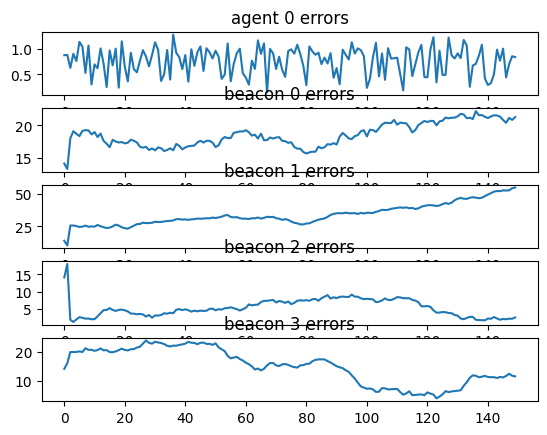

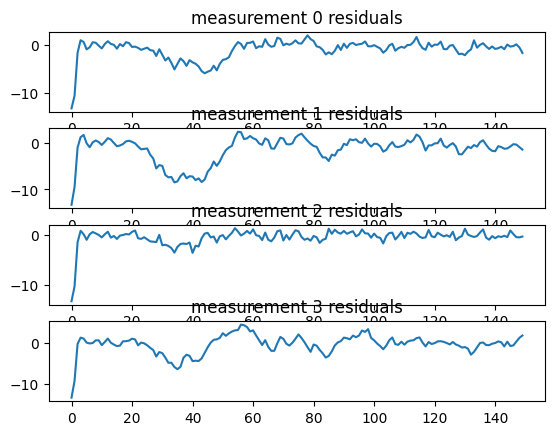

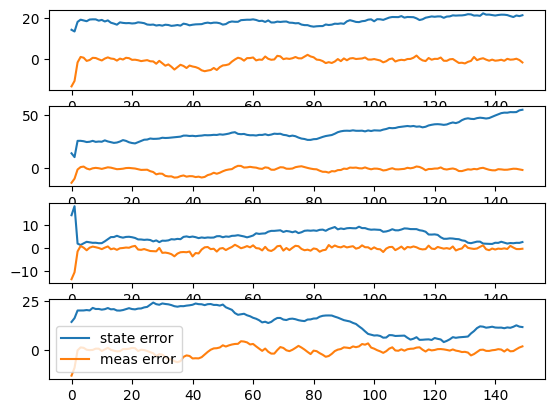

In [9]:
#calc errors
errors = np.zeros((n_steps, TOTAL_STATE_SIZE))
for i in range(n_steps):
    errors[i] = x[:,i] - mean_log[i]
pd.DataFrame(errors).to_csv(f'{exp_folder}/errors.csv', index = False, header = False)

#plot errors, split by aagent and beacons in different subplots for each agent and beacon
if 1:
    fig, axs = plt.subplots(NUM_OF_AGENTS + NUM_OF_BEACONS, 1)
    for i in range(NUM_OF_AGENTS):
        axs[i].plot(np.linalg.norm(errors[:,get_agent_index(i)],axis = 1))
        axs[i].set_title(f'agent {i} errors')
    for j in range(NUM_OF_BEACONS):
        axs[NUM_OF_AGENTS + j].plot(np.linalg.norm(errors[:,get_beacon_index(j)],axis = 1))
        axs[NUM_OF_AGENTS + j].set_title(f'beacon {j} errors')
    plt.show()
    
# plot the measermnt resedules
meas_residual = np.zeros((n_steps, RANGE_MEASUREMENT_SIZE))
for i in range(n_steps):
    meas_residual[i] = calculate_true_range_meas(mean_log[i]) - calculate_true_range_meas(x[:,i])
if 1:
    fig, axs = plt.subplots(RANGE_MEASUREMENT_SIZE, 1)
    for i in range(RANGE_MEASUREMENT_SIZE):
        axs[i].plot(meas_residual[:,i])
        axs[i].set_title(f'measurement {i} residuals')
    plt.show()
# put state error and meas error in the same subplots
if 1:
    fig, axs = plt.subplots(NUM_OF_BEACONS, 1)
    for i in range(NUM_OF_BEACONS):
        axs[i].plot(np.linalg.norm(errors[:,get_beacon_index(i)],axis = 1))
        axs[i].plot(meas_residual[:,i])
        # axs[i].set_title(f'state {i} errors')
    plt.legend(['state error', 'meas error'])
    plt.show()